In [1]:
import cv2
import os
import numpy as np
from google.colab.patches import cv2_imshow

In [2]:
img_dir = "panorama"
images = []

for filename in sorted(os.listdir(img_dir)):
    if not filename.endswith(".jpg"):
        continue

    img = cv2.imread(os.path.join(img_dir, filename))

    if img is not None:
        h, w = img.shape[:2]
        img_resized = cv2.resize(img, (w // 2, h // 2))
        images.append(img_resized)

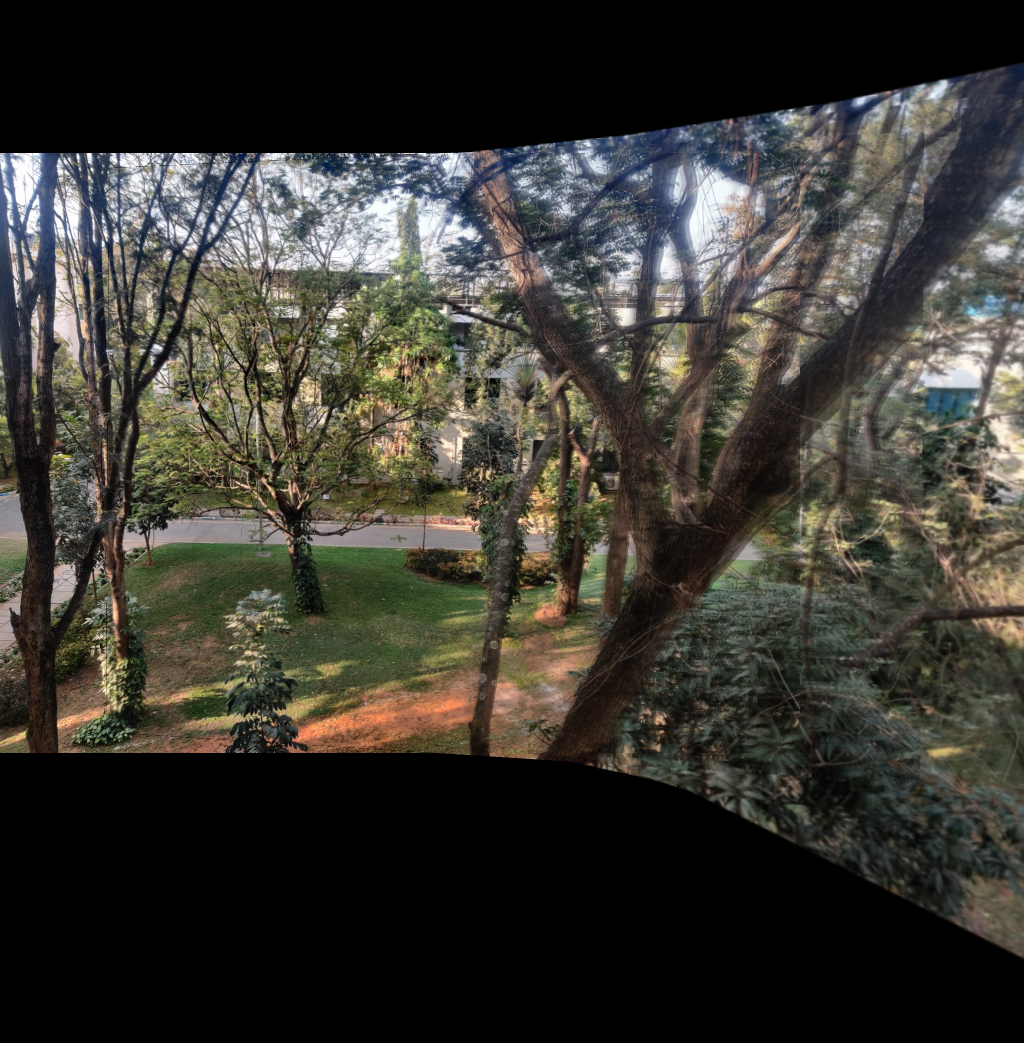

In [3]:
sift = cv2.SIFT_create()
combined_image = images[0]

for i in range(1, len(images)):
    kp1, des1 = sift.detectAndCompute(combined_image, None)
    kp2, des2 = sift.detectAndCompute(images[i], None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)[:50]

    img_matches = cv2.drawMatches(
        combined_image, kp1, images[i], kp2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # Extract location of good matches
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Compute homography
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Compute the corners of the new image
    h1, w1 = combined_image.shape[:2]
    h2, w2 = images[i].shape[:2]
    corners = np.float32([[0,0], [0,h2], [w2,h2], [w2,0]]).reshape(-1, 1, 2)
    warped_corners = cv2.perspectiveTransform(corners, H)

    # Get min and max points to determine new canvas size
    all_corners = np.concatenate((np.float32([[0,0], [0,h1], [w1,h1], [w1,0]]).reshape(-1,1,2), warped_corners), axis=0)
    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    # Translation matrix to shift the panorama
    translation = [-xmin, -ymin]
    T = np.array([[1, 0, translation[0]], [0, 1, translation[1]], [0, 0, 1]])

    # Warp the current combined image to the new canvas size
    new_width = xmax - xmin
    new_height = ymax - ymin
    warped_combined = cv2.warpPerspective(combined_image, T.dot(H), (new_width, new_height))

    # Create a mask for the warped combined image (non-black pixels)
    mask_combined = cv2.cvtColor(warped_combined, cv2.COLOR_BGR2GRAY)
    _, mask_combined = cv2.threshold(mask_combined, 1, 255, cv2.THRESH_BINARY)

    # Define ROI on the canvas where the new image will be placed
    y_offset, x_offset = translation[1], translation[0]
    roi = warped_combined[y_offset:y_offset+h2, x_offset:x_offset+w2]

    # Create an overlapping mask: where the roi already has content
    overlap_mask = (roi.sum(axis=2) > 0)

    # Initialize blended ROI as a copy of the new image
    blended_roi = images[i].copy()

    # Blend only in the overlapping region using cv2.addWeighted
    alpha = 0.5
    if np.any(overlap_mask):
        # Convert regions to float32 for blending then back to uint8
        roi_overlap = roi[overlap_mask].astype(np.float32)
        new_overlap = images[i][overlap_mask].astype(np.float32)
        blended = cv2.addWeighted(roi_overlap, alpha, new_overlap, 1 - alpha, 0)
        blended_roi[overlap_mask] = blended.astype(np.uint8)

    # For areas with no overlap (roi black), new image pixels are already used.
    warped_combined[y_offset:y_offset+h2, x_offset:x_offset+w2] = blended_roi

    # Update the combined image for the next iteration
    combined_image = warped_combined

cv2_imshow(combined_image) # Display final result